In [1]:
# Monta o Google Drive para acessar arquivos
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageEnhance

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D,
    concatenate, BatchNormalization, Activation, LeakyReLU
)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers import Dense, Conv2DTranspose, UpSampling2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, UpSampling2D, Dropout

from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, MeanIoU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1_l2

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

import h5py

In [3]:
# Caminho para o arquivo HDF5 no Google Drive
file_path = '/content/drive/MyDrive/PROJETO/g5_dataset_augmented_processed_28_ago.h5'

# Carregando os arrays do arquivo HDF5
with h5py.File(file_path, 'r') as h5f:
    X__train = h5f['x_train'][:]
    X_test = h5f['x_test'][:]
    y_train = h5f['y_train'][:]
    y_test = h5f['y_test'][:]

In [4]:
X__train.shape, X_test.shape, y_train.shape, y_test.shape

((9570, 128, 128, 3),
 (798, 128, 128, 3),
 (9570, 128, 128, 3),
 (798, 128, 128, 3))

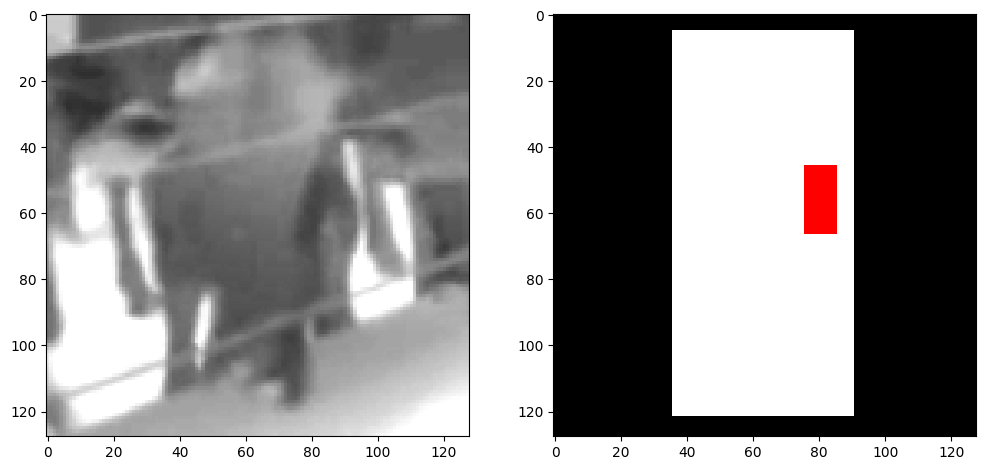

In [5]:
random_index = np.random.randint(0, y_test.shape[0])

imageX = X__train[random_index]
image = y_train[random_index]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(imageX)


plt.subplot(1, 2, 2)
plt.imshow(image)

In [6]:
import numpy as np

def transform_red_to_white(mask):
    # Criando uma cópia da máscara para modificar
    white_mask = np.copy(mask)

    # Definindo os pixels vermelhos (255, 0, 0) como branco (255, 255, 255)
    red_pixels = (mask[:, :, 0] == 255) & (mask[:, :, 1] == 0) & (mask[:, :, 2] == 0)
    white_mask[red_pixels] = [255, 255, 255]

    # Invertendo os pixels brancos (255, 255, 255) para preto (0, 0, 0)
    white_pixels = (mask[:, :, 0] == 255) & (mask[:, :, 1] == 255) & (mask[:, :, 2] == 255)
    white_mask[white_pixels] = [0, 0, 0]

    # Garantindo que os olhos vermelhos agora sejam brancos
    white_mask[red_pixels] = [255, 255, 255]

    # Retornando a máscara final
    return white_mask


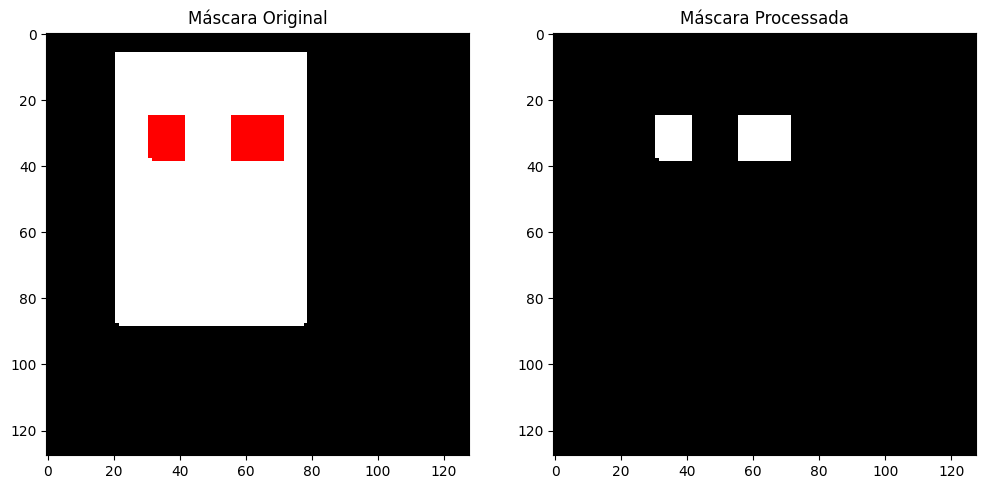

In [7]:
index = 0  # Índice da imagem de exemplo para inspeção
original_mask = y_train[index]
processed_mask = transform_red_to_white(original_mask)

# Plotando a máscara original e a processada para comparação
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Máscara Original")
plt.imshow(original_mask)

plt.subplot(1, 2, 2)
plt.title("Máscara Processada")
plt.imshow(processed_mask, cmap='gray')

In [8]:
y_train_processed = np.array([transform_red_to_white(mask) for mask in y_train])
y_test_processed = np.array([transform_red_to_white(mask) for mask in y_test])

In [16]:
y_train_processed.shape
y_test_processed.shape

(798, 128, 128, 3)

In [20]:
def binarize_masks(masks, threshold=127):
    """
    Aplica binarização em todas as máscaras no lote.

    Parâmetros:
    masks -- lote de imagens/máscaras no formato (N, altura, largura, canais)
    threshold -- valor de corte para binarização (default é 127)

    Retorno:
    binary_masks -- máscaras binarizadas com valores 0 ou 1
    """
    # Convertendo as máscaras para escala de cinza ao longo do eixo dos canais
    gray_masks = np.mean(masks, axis=-1)  # Média dos 3 canais (conversão para tons de cinza)

    # Aplicando o threshold para binarizar as máscaras
    binary_masks = np.where(gray_masks > threshold, 1, 0)

    return binary_masks

y_train_processed = binarize_masks(y_train_processed)
y_test_processed = binarize_masks(y_test_processed)

In [21]:
y_train_processed.shape
y_test_processed.shape

(798, 128, 128)

In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Input, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_lightweight_unet(input_shape):
    # Entrada
    inputs = Input(input_shape)

    # Encoder
    # Bloco 1
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.1)(p1)

    # Bloco 2
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.1)(p2)

    # Bloco 3
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.2)(p3)

    # Bloco 4
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(0.2)(p4)

    # Bridge
    b = Conv2D(256, (3, 3), activation='relu', padding='same')(p4)
    b = BatchNormalization()(b)
    b = Dropout(0.3)(b)

    # Decoder
    # Bloco 6
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(b)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Dropout(0.2)(c6)

    # Bloco 7
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Dropout(0.2)(c7)

    # Bloco 8
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(0.1)(c8)

    # Bloco 9
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Dropout(0.1)(c9)

    # Camada de saída
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Especificando o tamanho da entrada
input_shape = (128, 128, 3)
unet_model = build_lightweight_unet(input_shape)

from tensorflow.keras import backend as K

def dice_loss(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    return 1 - (2. * intersection + K.epsilon()) / (K.sum(y_true) + K.sum(y_pred) + K.epsilon())

from tensorflow.keras.callbacks import LearningRateScheduler

# Função de learning rate cíclico
def cyclical_learning_rate(epoch, lr):
    base_lr = 1e-5  # valor mínimo da taxa de aprendizado
    max_lr = 1e-3  # valor máximo da taxa de aprendizado
    step_size = 10  # quantidade de épocas por ciclo
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    new_lr = base_lr + (max_lr - base_lr) * np.maximum(0, (1 - x))
    return new_lr

# Callback para ajustar o learning rate a cada época
lr_scheduler = LearningRateScheduler(cyclical_learning_rate)

# Compilando o modelo
unet_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC()
    ]
)

unet_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_14 (Conv2D)          (None, 128, 128, 16)         448       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_13 (Ba  (None, 128, 128, 16)         64        ['conv2d_14[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv2d_15 (Conv2D)          (None, 128, 128, 16)         2320      ['batch_normalization_13

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train_train, y_val_val = train_test_split(X__train, y_train_processed, test_size=0.2, random_state=42)

# Verificando os tamanhos dos conjuntos
print(f"Tamanho do conjunto de treinamento: {X_train.shape}")
print(f"Tamanho do conjunto de validação: {X_val.shape}")
print(f"Tamanho do conjunto de treino: {y_train_train.shape}")
print(f"Tamanho do conjunto de validação: {y_val_val.shape}")

Tamanho do conjunto de treinamento: (7656, 128, 128, 3)
Tamanho do conjunto de validação: (1914, 128, 128, 3)
Tamanho do conjunto de treino: (7656, 128, 128)
Tamanho do conjunto de validação: (1914, 128, 128)


In [24]:
print(f"Tamanho do conjunto de treino: {y_train_train.shape}")
print(f"Tamanho do conjunto de validação: {y_val_val.shape}")

Tamanho do conjunto de treino: (7656, 128, 128)
Tamanho do conjunto de validação: (1914, 128, 128)


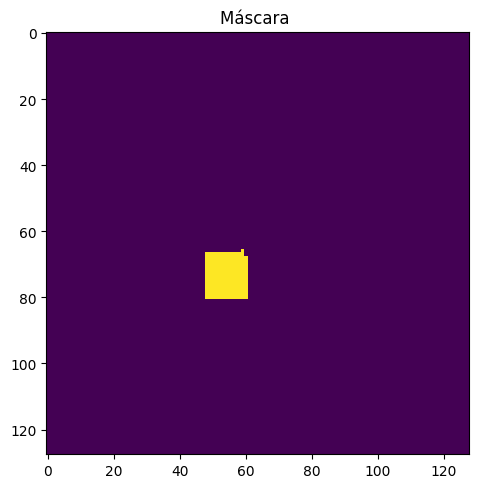

In [25]:
index = 0  # Índice da imagem de exemplo para inspeção
mask = y_train_train[index]

# Plotando a máscara original e a processada para comparação
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Máscara ")
plt.imshow(mask)

In [26]:
# Configurando early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Treinando o modelo
history = unet_model.fit(X_train, y_train_train,
                         epochs=40,
                         batch_size=16,
                         validation_data=(X_val, y_val_val),
                         callbacks=[early_stopping, lr_scheduler])

Epoch 1/40
479/479 [==============================] - 30s 28ms/step - loss: 0.7638 - binary_accuracy: 0.4995 - precision_1: 0.0139 - recall_1: 0.5310 - auc_1: 0.5192 - val_loss: 0.7086 - val_binary_accuracy: 0.4882 - val_precision_1: 0.0150 - val_recall_1: 0.5973 - val_auc_1: 0.5479 - lr: 1.0000e-05
Epoch 2/40
479/479 [==============================] - 9s 20ms/step - loss: 0.6329 - binary_accuracy: 0.7332 - precision_1: 0.0209 - recall_1: 0.4230 - auc_1: 0.6253 - val_loss: 0.5385 - val_binary_accuracy: 0.9593 - val_precision_1: 0.1284 - val_recall_1: 0.3729 - val_auc_1: 0.7981 - lr: 1.0900e-04
Epoch 3/40
479/479 [==============================] - 9s 19ms/step - loss: 0.4005 - binary_accuracy: 0.9731 - precision_1: 0.1249 - recall_1: 0.1760 - auc_1: 0.7156 - val_loss: 0.2729 - val_binary_accuracy: 0.9862 - val_precision_1: 0.3625 - val_recall_1: 0.0944 - val_auc_1: 0.8695 - lr: 2.0800e-04
Epoch 4/40
479/479 [==============================] - 9s 19ms/step - loss: 0.1671 - binary_accuracy

In [27]:
print(f"Forma de X_test: {X_test.shape}")
print(f"Forma de y_test_processed: {y_test_processed.shape}")

Forma de X_test: (798, 128, 128, 3)
Forma de y_test_processed: (798, 128, 128)


In [30]:
# Avaliando o modelo
y_test_processed = np.array([transform_red_to_white(mask) for mask in y_test])
y_test_processed = binarize_masks(y_test_processed)
result = unet_model.evaluate(X_test, y_test_processed)

# Verifique quantos valores foram retornados
print(result)

# Ajuste o número de variáveis de acordo com o retorno
(test_loss, test_accuracy, test_precision, test_recall, test_auc) = result

# Exibindo as métricas
print(f'Loss no conjunto de teste: {test_loss:.4f}')
print(f'Acurácia no conjunto de teste: {test_accuracy*100:.2f}%')
print(f'Recall no conjunto de teste: {test_recall*100:.2f}%')
print(f'Precisão no conjunto de teste: {test_precision*100:.2f}%')
print(f'AUC no conjunto de teste: {test_auc:.4f}')

25/25 [==============================] - 2s 39ms/step - loss: 0.0304 - binary_accuracy: 0.9881 - precision_1: 0.8028 - recall_1: 0.1125 - auc_1: 0.9779
[0.030357807874679565, 0.9881360530853271, 0.8027623295783997, 0.11247596144676208, 0.9779081344604492]
Loss no conjunto de teste: 0.0304
Acurácia no conjunto de teste: 98.81%
Recall no conjunto de teste: 11.25%
Precisão no conjunto de teste: 80.28%
AUC no conjunto de teste: 0.9779


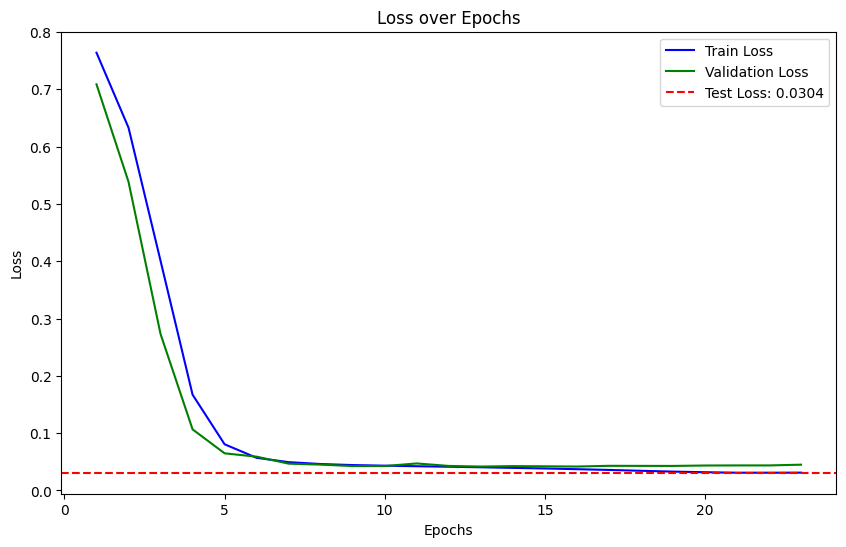

In [31]:
import matplotlib.pyplot as plt

# Obter os valores de loss e val_loss do histórico de treinamento
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotando o gráfico
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))

# Gráfico de loss de treinamento
plt.plot(epochs, train_loss, 'b-', label='Train Loss')

# Gráfico de loss de validação
plt.plot(epochs, val_loss, 'g-', label='Validation Loss')

# Plotar o loss de teste (como uma linha horizontal para comparação)
plt.axhline(y=test_loss, color='r', linestyle='--', label=f'Test Loss: {test_loss:.4f}')

# Configurações do gráfico
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Mostrar o gráfico
plt.show()

25/25 [==============================] - 1s 6ms/step


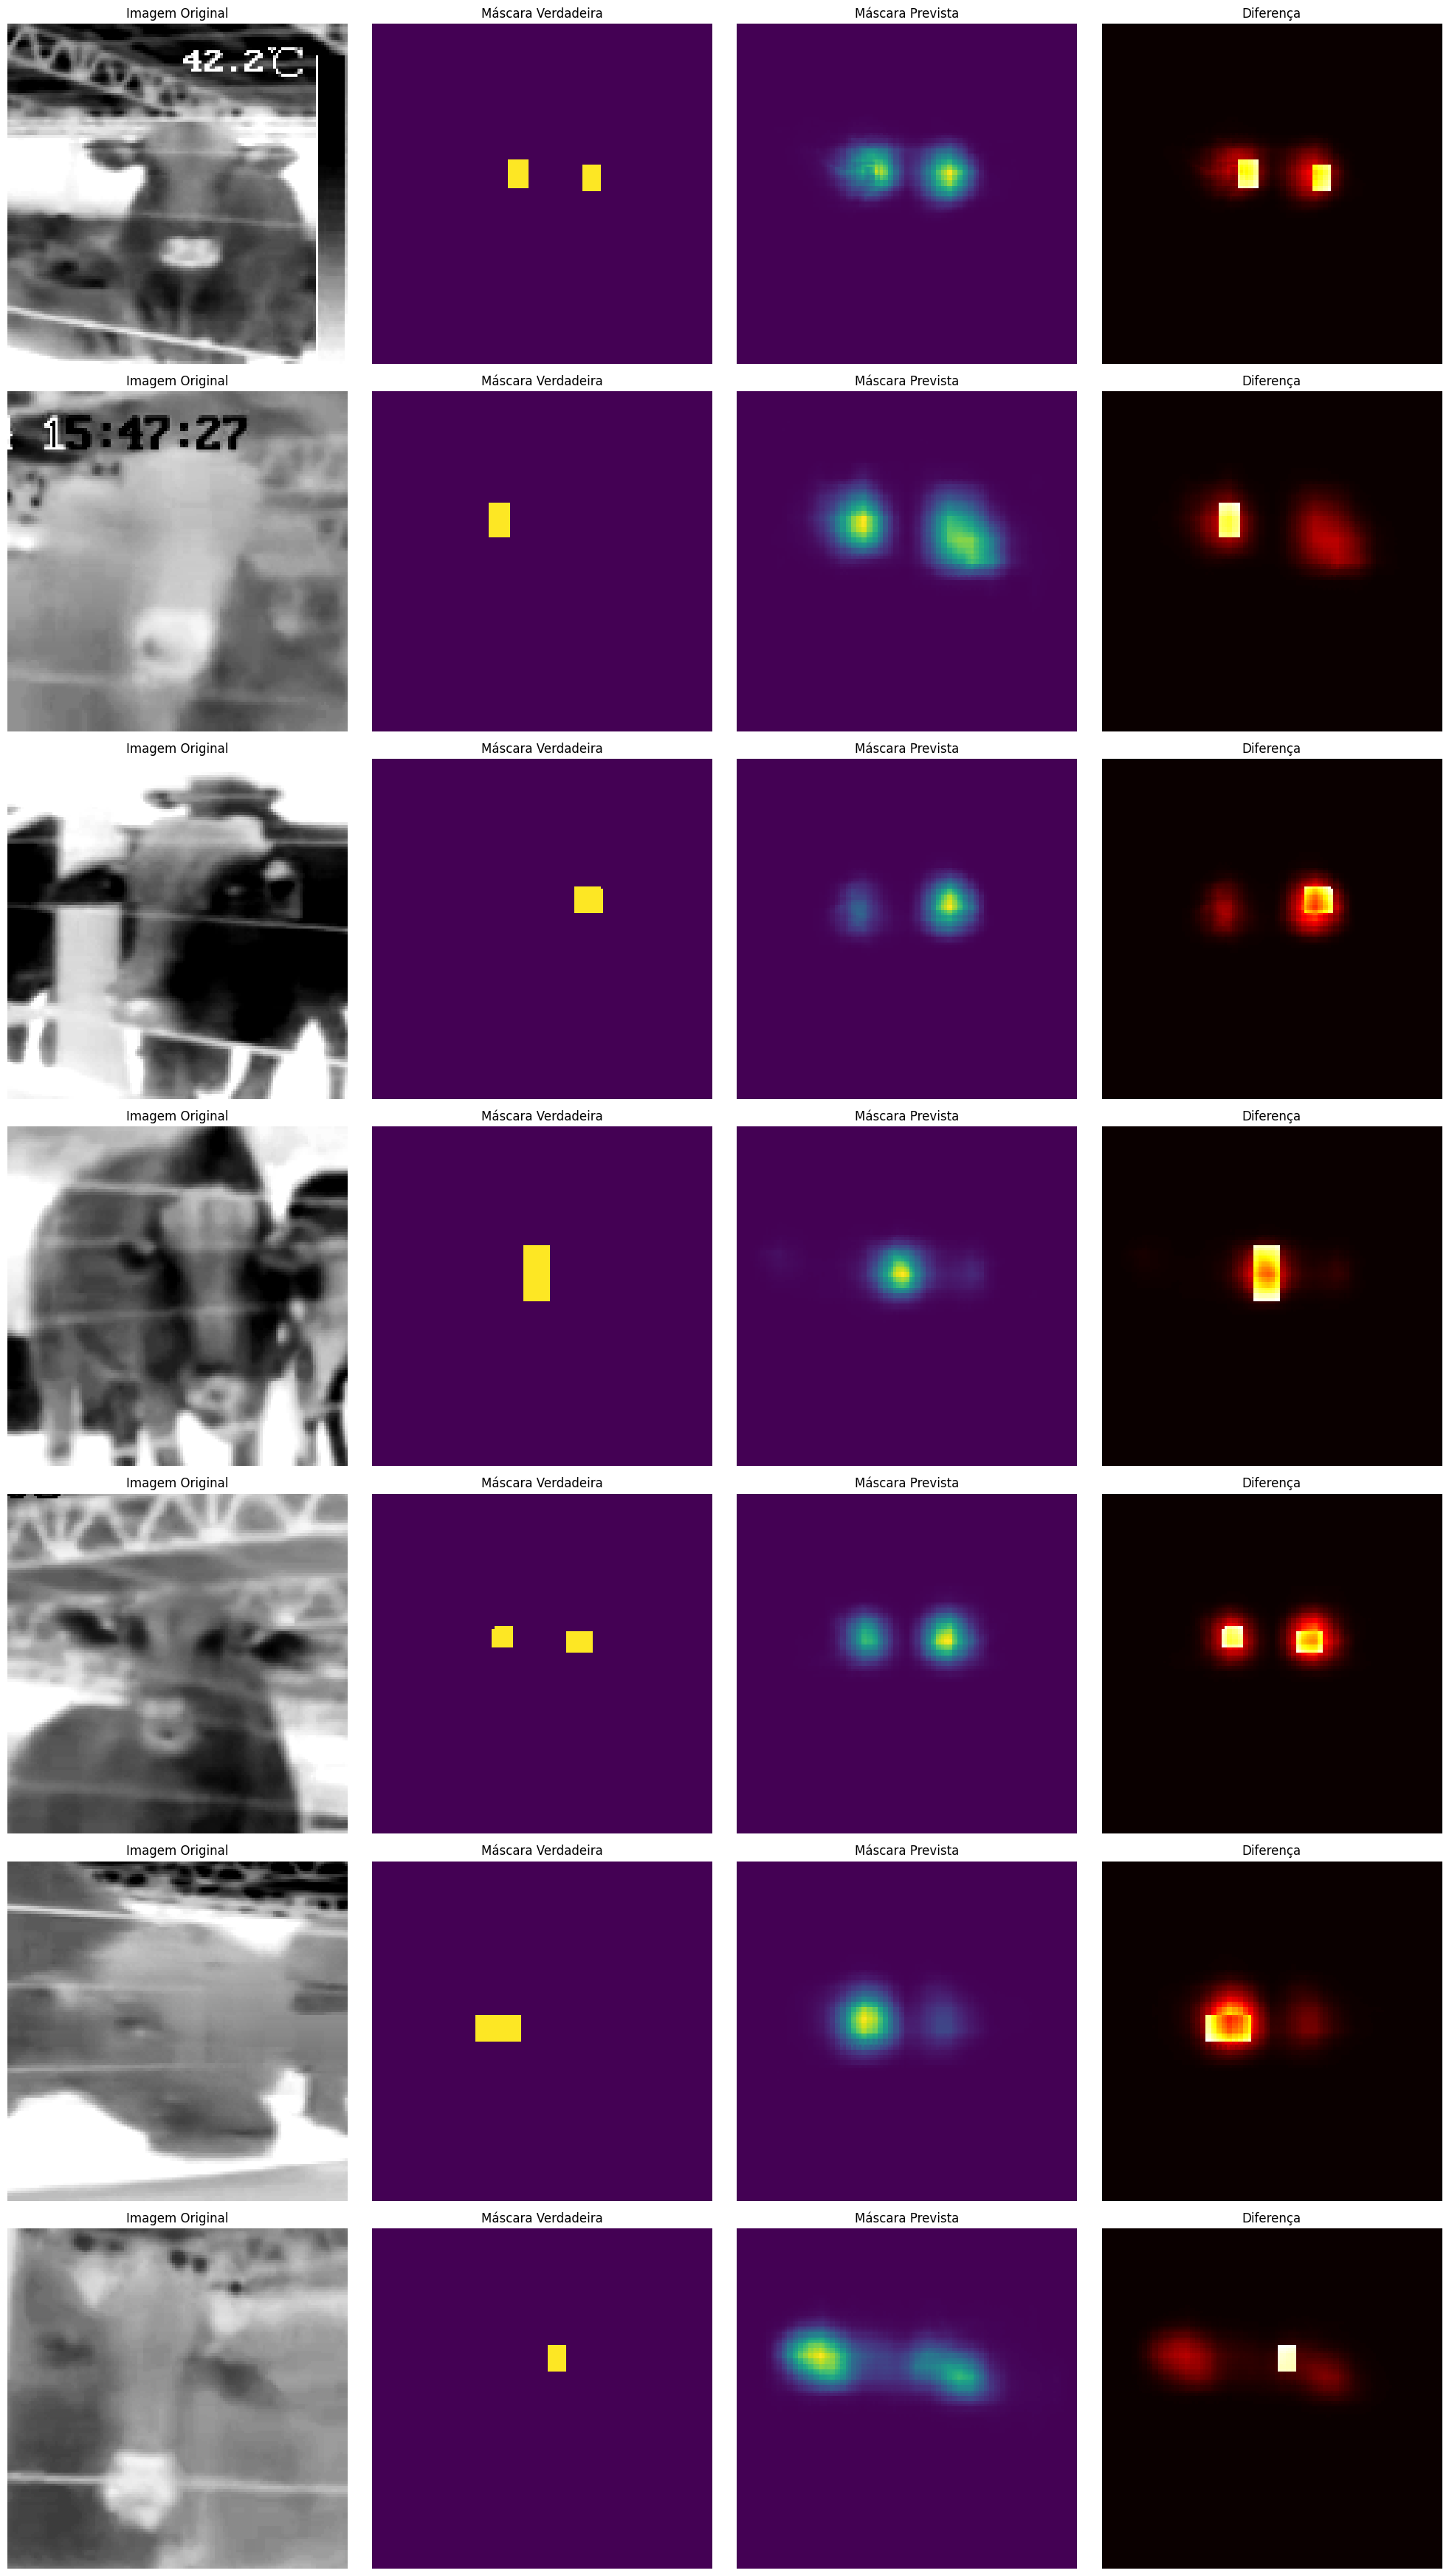

In [32]:
# Prevendo os valores do conjunto de teste
y_pred = unet_model.predict(X_test)

# Função para visualizar os resultados
def visualize_results(X, y_true, y_pred, num_samples=7):

    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5*num_samples))

    for i in range(num_samples):
        # Imagem Original
        axes[i, 0].imshow(np.squeeze(X[i]), cmap='viridis')
        axes[i, 0].set_title('Imagem Original')
        axes[i, 0].axis('off')

        # Máscara Verdadeira
        axes[i, 1].imshow(np.squeeze(y_true[i]), cmap='viridis')
        axes[i, 1].set_title('Máscara Verdadeira')
        axes[i, 1].axis('off')

        # Máscara Prevista
        axes[i, 2].imshow(np.squeeze(y_pred[i]), cmap='viridis')
        axes[i, 2].set_title('Máscara Prevista')
        axes[i, 2].axis('off')

        # Diferença entre a Máscara Verdadeira e Prevista
        diff = np.abs(np.squeeze(y_true[i]) - np.squeeze(y_pred[i]))
        axes[i, 3].imshow(diff, cmap='hot')
        axes[i, 3].set_title('Diferença')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

# Visualizando os resultados
visualize_results(X_test, y_test_processed, y_pred)


In [33]:
# Salvando o modelo treinado
unet_model.save('/content/drive/MyDrive/PROJETO/unet_vgg16_eye_segmentation_10_09.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
